In [1]:
# Citations
# GBIF.org (15 June 2025) GBIF Occurrence Download  https://doi.org/10.15468/dl.mhxdcy
# Data was obtained from GBIF-NZ, it includes records from 6 datasets: iNaturalist Research-grade Observations Observation.org, Nature data from around the World, Auckland Museum Land Vertebrates Collection, Xeno-canto - Bird sounds from around the world, NABU|naturgucker, MVZ Egg and Nest Collection (Arctos)
# There were 4258 occurances in the original dataset, but this was reduced to 4107 occurances as a result of data cleaning.
# Of the original 4258 occurances, 581 were takahe (Porphyrio hochstetteri) and 3621 were pukeko (Porphyrio melanotus subsp. melanotus).
# The data cleaning and downloading of the images was performed in Rstudio.

In [2]:
# Loading packages
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
import os
import shutil
from PIL import Image
import cv2
from multiprocessing import Pool


In [3]:
# Sorting images into files
source_folder = "Train_data"

# Define the destination folders for "Takahe" and "Pukeko"
takahe_folder = "Train_data/Takahe"
pukeko_folder = "Train_data/Pukeko"

# Ensuring the destination folders exist, and if they don't, creating them
os.makedirs(takahe_folder, exist_ok=True)
os.makedirs(pukeko_folder, exist_ok=True)

# Loop over each file in the source folder
for filename in os.listdir(source_folder):
    # Create the full path for the file
    src_file = os.path.join(source_folder, filename)
    
    # Process only files (skip directories)
    if os.path.isfile(src_file):
        # Convert filename to lowercase for case-insensitive matching
        lower_filename = filename.lower()
        
        # Check if filename contains "takahe" or "pukeko" and sort image into folders based on filename
        if "hochstetteri" in lower_filename:
            dest_file = os.path.join(takahe_folder, filename)
            shutil.move(src_file, dest_file)
            #print(f"Moved '{filename}' to {takahe_folder}") <- This is here for debugging
        elif "melanotus" in lower_filename:
            dest_file = os.path.join(pukeko_folder, filename)
            shutil.move(src_file, dest_file)
            #print(f"Moved '{filename}' to {pukeko_folder}")

In [4]:
# Checking that none of the images are in the wrong class folder
for file in os.listdir("Train_data/Takahe"):
    if "melanotus" in file:
        print("The filename contains the word 'melanotus'.")

for file in os.listdir("Train_data/Pukeko"):
    if "hochstetteri" in file:
        print("The filename contains the word 'hochstetteri'.")

In [5]:
Images = ImageFolder(root = "Train_data")

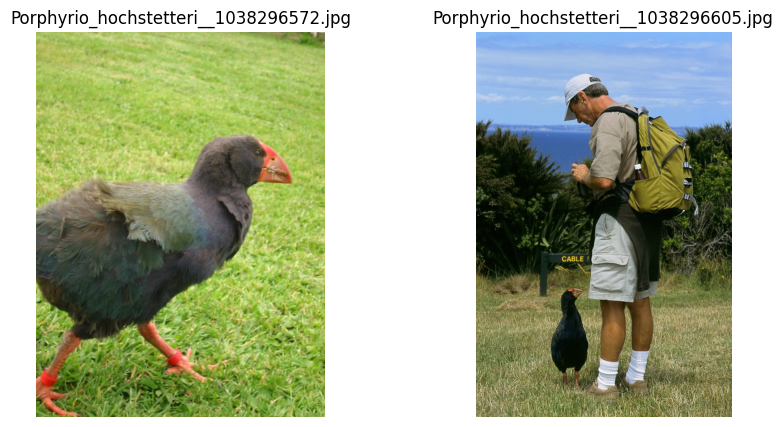

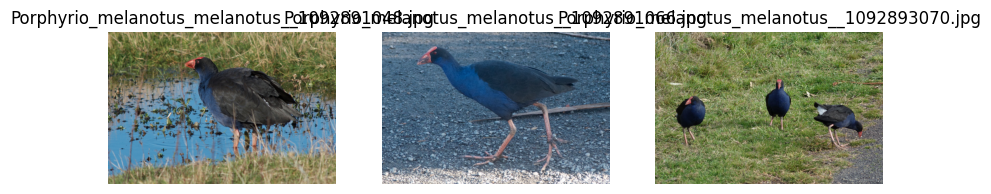

In [6]:
# Checking that images are displaying correctly in both folders
def image_display(sub_folder, starting_image_index, num_of_images):
    folder_path = "Train_data/" + str(sub_folder)
    # List all image files
    image_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
    # Select number of images
    first_two_images = image_files[starting_image_index:num_of_images]
    # # Plot images
    fig, axes = plt.subplots(1, (num_of_images-starting_image_index), figsize=(10, 5))
    for i, img_name in enumerate(first_two_images):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(img_name)
        axes[i].axis("off")
    plt.show()

image_display("Takahe", 0, 2)
image_display("Pukeko", 41, 44)

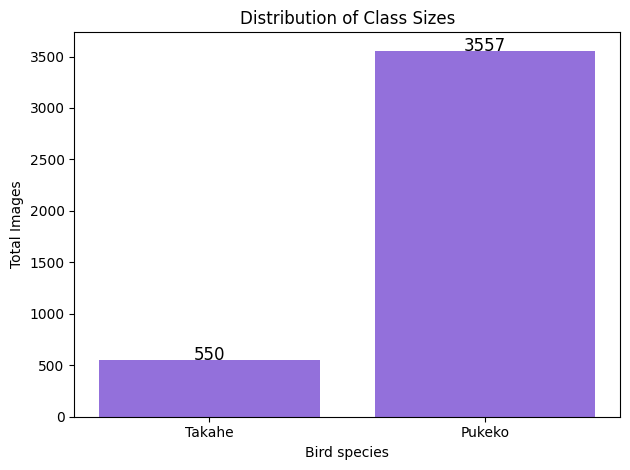

In [7]:
# Histogram of class sizes to check if there's a class size imbalance
class_size = {'Takahe': len(os.listdir('Train_data/Takahe')),
                  'Pukeko': len(os.listdir('Train_data/Pukeko'))}

plt.bar(class_size.keys(), class_size.values(), color = 'mediumpurple')
plt.title("Distribution of Class Sizes")
plt.xlabel('Bird species')
plt.ylabel('Total Images')
for i, (species, count) in enumerate(class_size.items()):
    plt.text(i, count + 1, str(count), ha = 'center', fontsize = 12)

plt.tight_layout()
# plt.savefig('class_distribution.png', dpi = 100, bbox_inches = 'tight')
plt.show()

In [8]:
print(len(os.listdir('Train_data/Takahe')))
# There are 550 Takahe in the dataset
print(len(os.listdir('Train_data/Pukeko')))
# There are 3557 Pukeko in the dataset

550
3557


In [9]:
# There are significantly more Pukeko images than Takahe images - the dataset is very imbalanced.
550/(3556+550)*100
# Takahe are only 13% of the dataset

13.395031660983925

In [10]:
# Initializing empty lists to store the sizes, resolutions and color_distributions of the images
sizes = []
resolutions = []
color_distributions = []

# Iterating over each image file in each subdirectory
for dirpath, dirnames, filenames in os.walk(source_folder):
    for filename in filenames:
        if filename.lower():
            # Load the image file using OpenCV
            img_path = os.path.join(dirpath, filename)
            img = cv2.imread(img_path)

            # Extracting the size of the image
            size = os.path.getsize(img_path)
            sizes.append(size)

            # Extracting the resolution of the image
            resolution = img.shape[:2]
            resolutions.append(resolution)

            # Extracting the color distribution of the image
            color_distribution = np.bincount(img.flatten(), minlength = 256)
            color_distributions.append(color_distribution)

# Converting the lists to numpy arrays for easier manipulation
sizes = np.array(sizes)
resolutions = np.array(resolutions)
color_distributions = np.array(color_distributions)

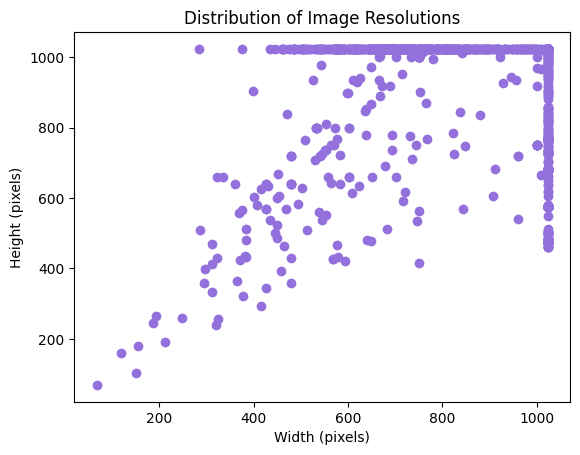

In [11]:
# Plotting a scatter plot of the image resolutions
plt.scatter(resolutions[:, 0], resolutions[:, 1], color = 'mediumpurple')
plt.title("Distribution of Image Resolutions")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
# plt.savefig('Distribution of Image Resolutions', dpi = 100, bbox_inches = 'tight')
plt.show()

In [12]:
# Looking at the resolutions info
print(type(resolutions))
print(len(resolutions))
print(resolutions[0, 0])

<class 'numpy.ndarray'>
4107
768


In [13]:
# Seeing how many images have a resolution of 600 by 600 or above
count_of_images = 0
for x in range(4106):
    if resolutions[x, 0] > 600 and resolutions[x, 1] > 600:
        count_of_images = count_of_images + 1
print(count_of_images)

3675


In [14]:
# Total pixels in dataset:
total_pixels = np.sum(resolutions[:, 0] * resolutions[:, 1])
total_pixels
# There are 3068787040 pixels in the dataset images

np.int64(3068787040)

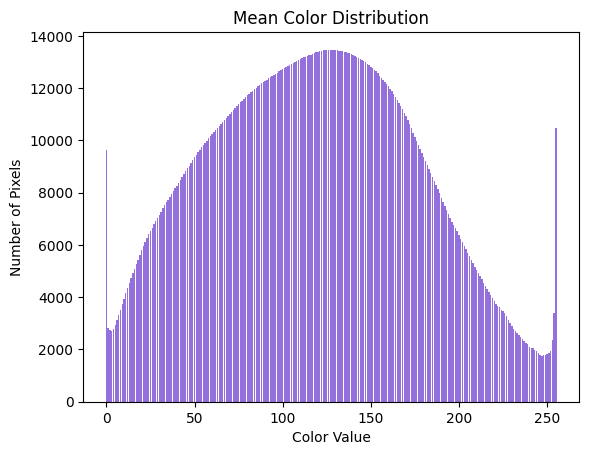

In [15]:
# Calculating the mean color distribution across all images
mean_color_distribution = np.mean(color_distributions, axis = 0)
# Plotting a bar chart of the mean color distribution
plt.bar(np.arange(256), mean_color_distribution, color = "mediumpurple")
plt.title("Mean Color Distribution")
plt.xlabel("Color Value")
plt.ylabel("Number of Pixels")
# plt.savefig('Mean Color Distribution.png', dpi = 100, bbox_inches = 'tight')
plt.show()
